In [129]:
import os
import cv2 
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle
from skimage.morphology import erosion, opening, square, disk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (12, 6)

In [130]:
def readSortedSlices(path):
    
    slices = []
    for s in os.listdir(path):
        slices.append(path + '/' + s)
        
    slices.sort(key = lambda s: int(s[s.find('_') + 1 : s.find('.')]))

    ID = slices[0][slices[0].find('/') + 1 : slices[0].find('_')]
    print('CT scan of Patient %s consists of %d slices.' % (ID, len(slices)))  
    return (slices, ID)

def readImg(path):
    img = cv2.imread(path)
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def getSliceImages(slices):
    
    return list(map(readImg, slices))

In [131]:
slices, PatientID = readSortedSlices('sample-dataset')
sliceImgs = getSliceImages(slices)

CT scan of Patient ID00007637202177411956430 consists of 30 slices.


Image Dimensions: (512, 512)


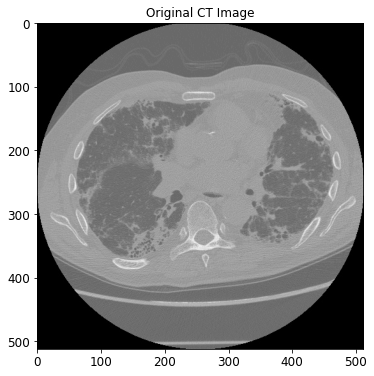

In [135]:
# Select a sample slice to work with
im = readImg('sample-dataset/ID00007637202177411956430_16.jpg')
plt.title('Original CT Image')
plt.imshow(im, cmap='gray')
print('Image Dimensions:', im.shape)

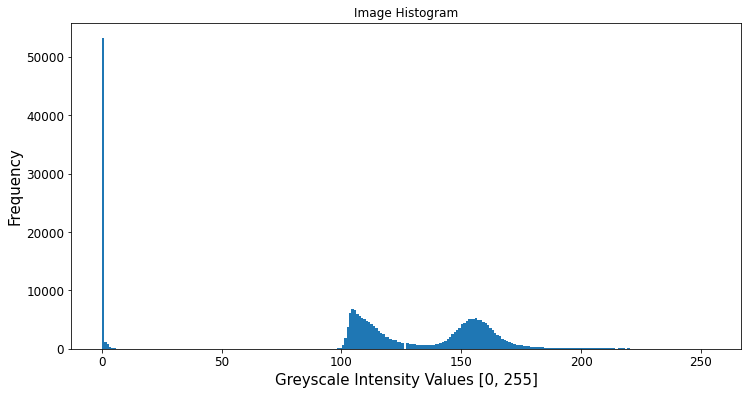

In [133]:
plt.figure(figsize = (12, 6))

plt.title('Image Histogram')
plt.xlabel('Greyscale Intensity Values [0, 255]')
plt.ylabel('Frequency')
plt.hist(im.ravel(), bins=256)
plt.show()

In [98]:
def plotSegmentedImg(img, segmented, K):
    
    # Plot the segmented image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')
    
    ax2.imshow(segmented)
    ax2.set_title('CT Image on Segmentation with KMeans of K = ' + str(K))

def plotHistogram(kmmodel, centers, K):
    plt.figure(figsize = (20, 10))

    colors = ['red', 'blue', 'green', 'purple', 'black']; i = 0

    # Center lines on the histogram
    for center in centers.values():
        plt.axvline(x = center, c = colors[i])
        plt.text(x = center + 5, 
                 y = 30000, 
                 s = "Center: " + str(center), 
                 c = colors[i])
        i+=1

    plt.axvline(x = center, c = 'black')
        plt.text(x = 135.07441462746587, 
                 y = 30000, 
                 s = str(135.07441462746587), 
                 c = 'black')
        
    plt.title('Image Histogram with Calculated Statistical Parameters')
    plt.xlabel('Greyscale Intensity Values [0, 255]')
    plt.ylabel('Frequency')


    N, bins, patches = plt.hist(im.ravel(), bins=256)

    for i in range(0, len(bins) - 1):
        label = kmmodel.predict([[i]])
        patches[i].set_facecolor(colors[label[0]])

    #handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in colors]
    #labels = ["Air in the Chest", "Background Material", "Body Tissue and Bone"]
    #plt.legend(handles, labels)

    plt.show()

IndentationError: unexpected indent (1038766813.py, line 29)

In [99]:
def applyKMeans(img, K, plot_segmented=0, plot_histogram=0):
    
    imflat = np.reshape(im, im.shape[0] * im.shape[1]).reshape(-1, 1)
        
    kmeans = KMeans(K)
    
    kmmodel = kmeans.fit(imflat)
    
    labels = kmmodel.labels_
    centers = kmmodel.cluster_centers_
    
    print(len(labels), 'Labels: \n', labels)
    
    # Center values correspond to intensity values 
    print(len(centers), 'Centers: \n', centers)
    
    # Print centers of labels
    centers_map = dict(zip(np.arange(K), centers))
    print('Labels with corresponding centers:', centers_map)
    
    segmented = np.array([centers_map[label] for label in labels]).reshape(img.shape[0], img.shape[1]) 

    segmented = segmented.astype(int)
    
    if plot_segmented:
        plotSegmentedImg(img, segmented, K)
    
    if plot_histogram:
        plotHistogram(kmmodel, centers_map, K)
    
    return segmented, labels, centers_map

262144 Labels: 
 [1 1 1 ... 1 1 1]
3 Centers: 
 [[1.12269714e+02]
 [8.82521695e-02]
 [1.57879115e+02]]
Labels with corresponding centers: {0: array([112.26971435]), 1: array([0.08825217]), 2: array([157.87911491])}


<Figure size 864x432 with 0 Axes>

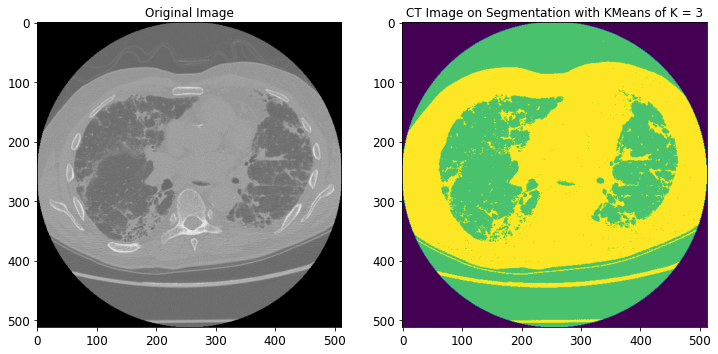

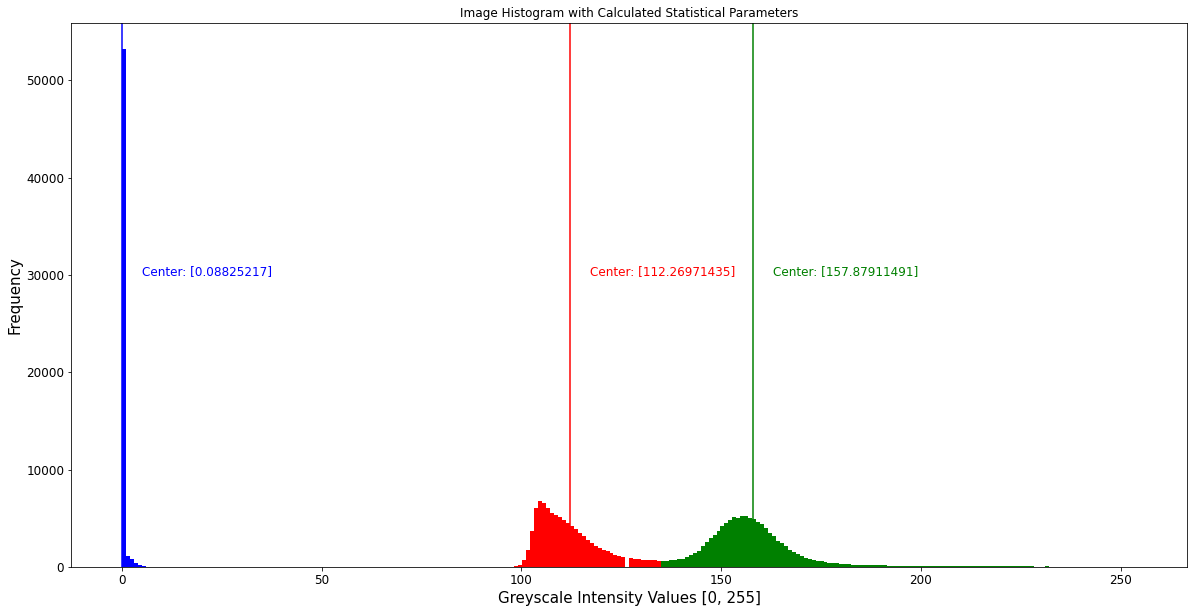

In [100]:
segmented, labels, centers = applyKMeans(im, 3, 1, 1)

In [92]:
centers

{0: array([157.87911491]), 1: array([0.08825217]), 2: array([112.26971435])}

In [97]:
threshold = (centers[0][0] + centers[2][0])/2
threshold

135.07441462746587

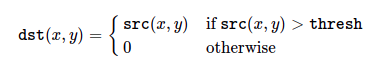

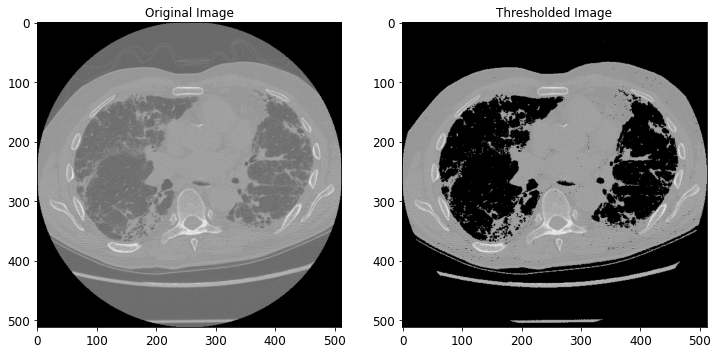

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title('Original Image')
ax1.imshow(im, cmap='gray')

retval, foreground = cv2.threshold(im, threshold, 255, cv2.THRESH_TOZERO) 
ax2.set_title('Thresholded Image')
ax2.imshow(foreground, cmap='gray')

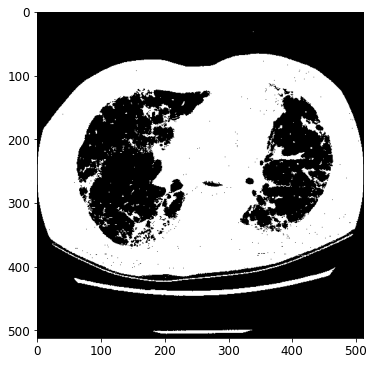

In [146]:
retval2, foreground_mask  = cv2.threshold(im, threshold, 255, cv2.THRESH_BINARY) 
plt.imshow(foreground_mask, cmap='gray')